In [1]:
from simMat_funcs import *

In [2]:
dataPath = '../Data/'
simMat_yr = np.load(dataPath + 'history_simMat.npy')

elemList = []
with open(f"{dataPath}/ElementList.txt",'r') as f:
    for line in f:
        elemList.append(line.strip())

elemList_AO = [] # Atomic weight ordered element list
for e in TP.keys():
    if e in elemList:
        elemList_AO.append(e)
            
min_yr = 1771
print(simMat_yr.shape)

(247, 103, 103)


# Meaning of 0s and nans

If element exists to this year, but similarity == 0, plot 0.

If element doesn't exist, then similarity == 0, but plot nan.

## Let's produce code to convert these data, into specific plots for each element.


In [3]:
def plot_SimPTBar(simMat_yr,year,element,min_yr):
    # Select simMat for this year
    arr_yr = simMat_yr[year-min_yr].copy()
    # Select a particular element
    X,Y = TP[element]

    # Generate a list of elements present at the given year
    c,elems_yr = 0,[]  # counter, element list
    for e in TP.keys():
        if e in elemList:
            # If all entries at this place are nan: they don't exist
            if (~np.isnan(arr_yr[:,c].all())): 
                c+=1
                elems_yr.append(e)

    # Select the array for the given element, for the given year
    arr_thisElem = arr_yr[:,elems_yr.index(element)]
    arr_thisElem[elems_yr.index(element)] = 0  # Remove this element's value, so it's white as well

    img = np.zeros((7,32))
    mask = img.copy()
    # Create a mask to wipe out nan entries, so they appear as white
    c = 0
    for e in elems_yr:
        x,y = TP[e]
        mask[x,y] = 1
        if ~np.isnan(arr_thisElem[c]):
            img[x,y] = arr_thisElem[c]
            c+=1

    mask[X,Y] = 0
    with np.errstate(invalid='ignore',divide='ignore'):
        img /= mask

    # Plot similarity PT for elem
    fig = plt.figure(figsize=(18,7))
    gs = fig.add_gridspec(2,2,  width_ratios=(99, 1), height_ratios=(6, 4),
                  #    left=0, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0.2)

    ax = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1, :])
    cbar = fig.add_subplot(gs[0,1])

    cmap = sns.color_palette("magma", as_cmap=True)
    sns.heatmap(img,ax=ax,cbar_ax=cbar,
                vmin=0,vmax=np.nanmax(img),
                cmap=cmap)

    ax.set_title(f'Replaceability of {element} in chemical formulas, Year = {year}', fontsize=20)

    ax.axis('off')

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    #ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)

    # Plot barplot
    df = (pd.Series(arr_thisElem,index=elems_yr)
          .reset_index()
          .rename(columns={'index':'Element',
                           0:'Occurences'}))
    df = df[df.Element != element]

    df['color'] = (df['Occurences']/df['Occurences'].max()).apply(cmap)
    ax1.bar(x=range(df.shape[0]) ,
            height=df['Occurences'],
            color=df['color'],edgecolor = "k")

    ax1.set_xticks(range(df.shape[0]))
    ax1.set_xticklabels(df['Element'],fontsize=8)
    ax1.set_xlim(-1,df.shape[0])

    # Put the element's symbol at it's position
    if len(element)==1:  tab = 0.2
    else:                tab = 0.02
    ax.text(Y+tab,X+0.7,element,fontsize=17)

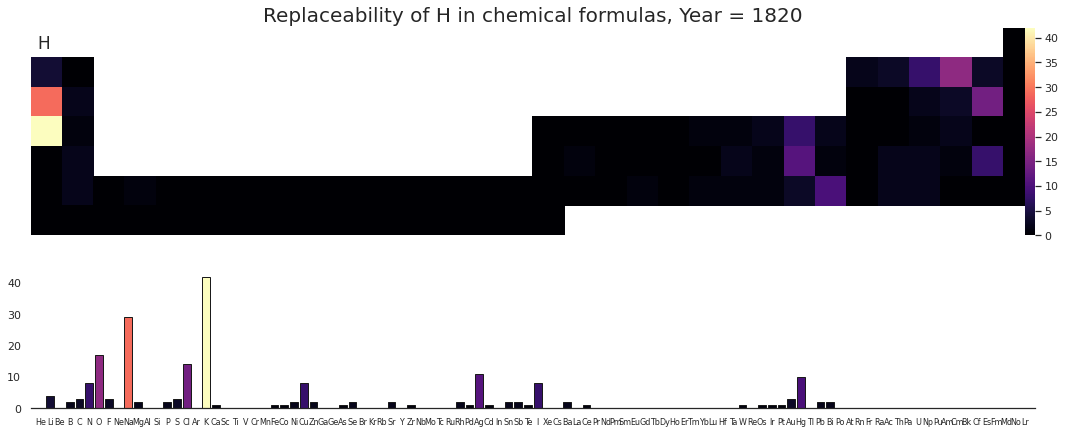

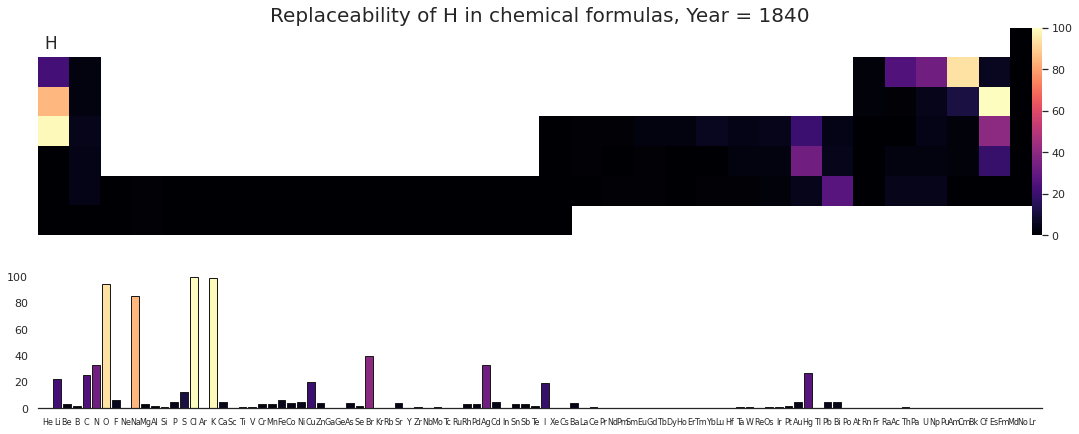

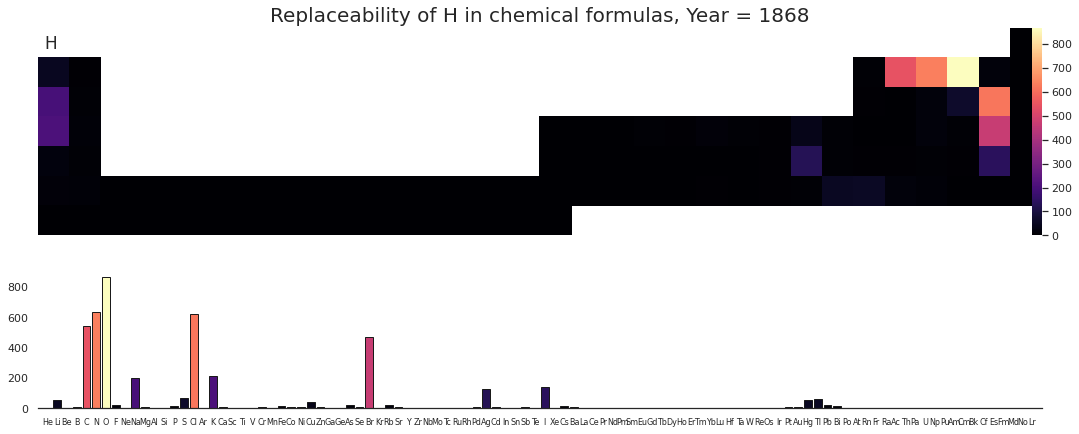

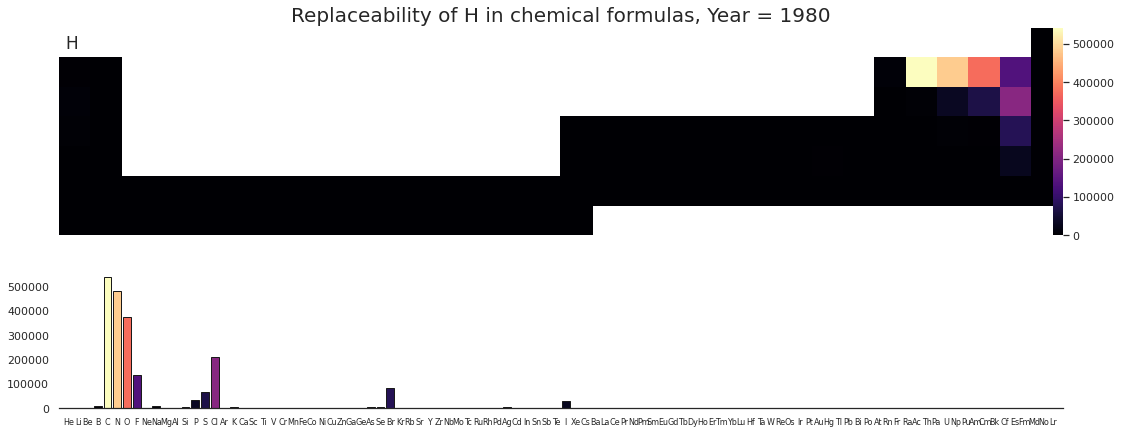

In [55]:
for y in [1820,1840,1868,1980]:#,2015]:
    plot_SimPTBar(simMat_yr,y,'H',min_yr)

# Plot similarity matrices for a given year.

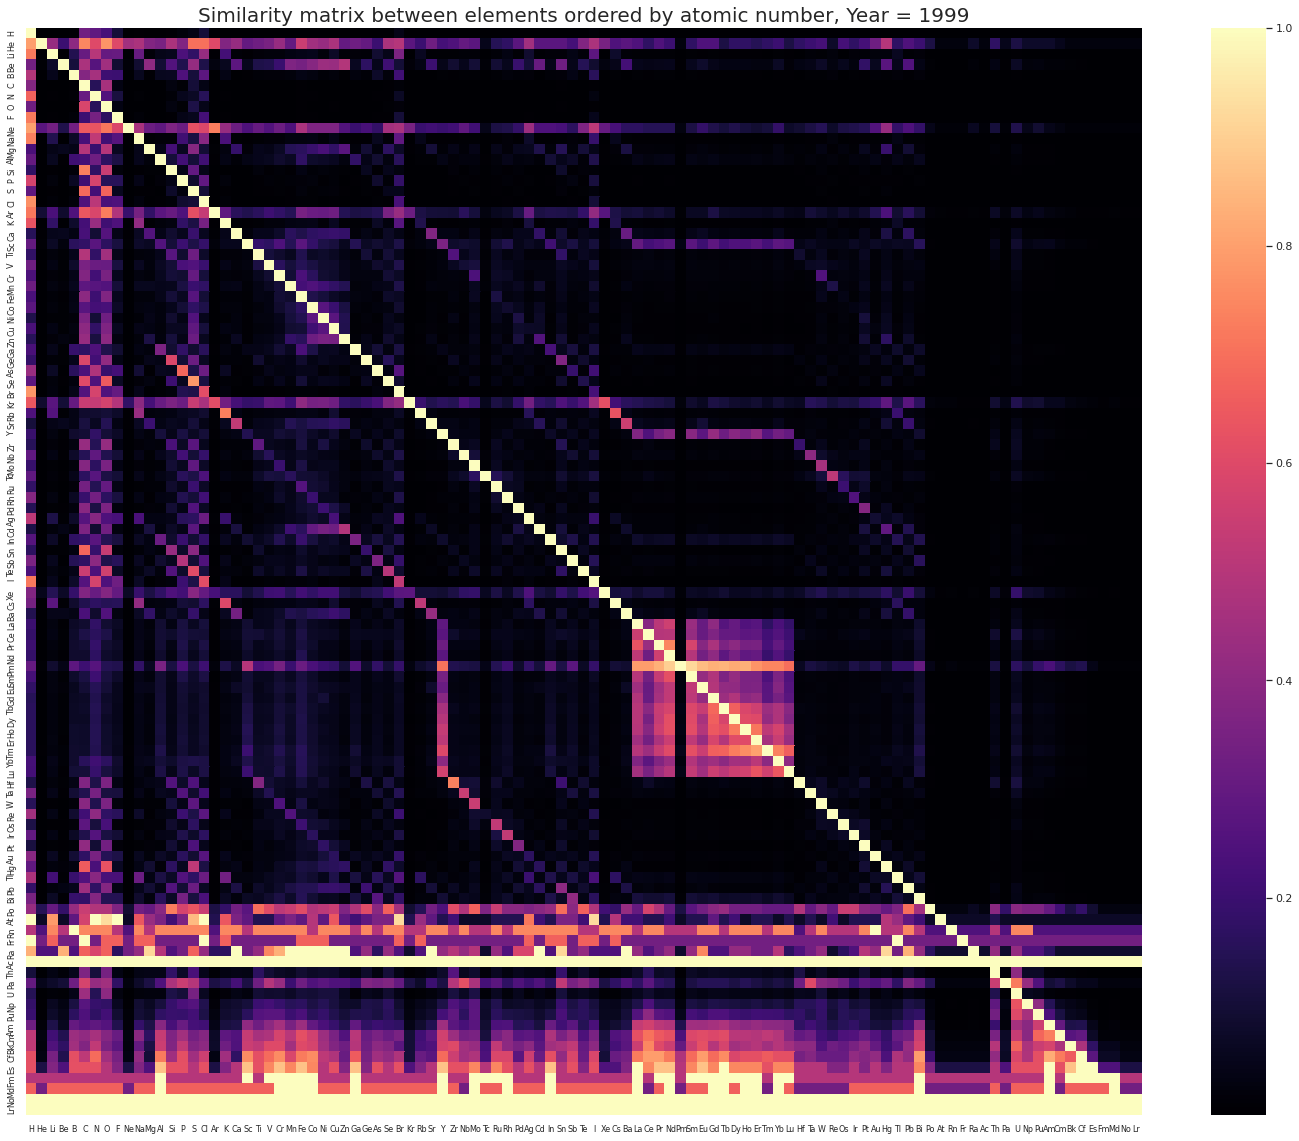

In [6]:
def plot_simMat_yr(year,min_yr=min_yr,save=False):
    
    diag = np.diag(simMat_yr[year - min_yr])
    with np.errstate(invalid='ignore',divide='ignore'):
        m = simMat_yr[year - min_yr]/diag
        m = m.T/(diag!=0)
    # Find which elements don't exist, to drop respective rows and cols
    isn = ~np.isnan(m).all(axis=0)
    m = m[isn][:,isn]
    #m = np.nan_to_num(m,0)
    
    fig,ax = plt.subplots(figsize=(25,20))
    ax.set_title(f"Similarity matrix between elements ordered by atomic number, Year = {year}",
                 fontsize=20)
    sns.heatmap(m,ax=ax,
                cmap=sns.color_palette("magma", as_cmap=True))
    
    #labl = [e for i,e in enumerate(TP.keys()) if (e in elemList and isn[i])]
    labl = [e for e in TP.keys() if e in elemList]
    tick = [i+0.5 for i in range(len(labl))]
    ax.set_xticks(tick)
    ax.set_yticks(tick)
    ax.set_xticklabels(labl,fontsize=8)
    ax.set_yticklabels(labl,fontsize=8)
    
    if save: plt.savefig(save,dpi=400,bbox_inches='tight')

plot_simMat_yr(1999)#,save='../Data/Results/SM_1867.png')

---

# Calculate mean(HND) from SMs.

### To calculate a mean, we sum, and then divide by the number of elements.

# sum(HND):

Let's first calculate HND for a single element, H.

Each other element x contributes a given distance, a specific number of times. This distance D(H,X) is the difference in PT groups, which has to be counted N(H,X) times, N(H,X) being the number of times both H and X appear in the same table.

Thus, each element contributes a total N(H,X)*D(H,X) to the sum, which results in the sum:

<br>
<font color='red' >
    $$
    sum(HND(H)) = N(H,H)*D(H,H) + N(H,He)*D(H,He) + N(H,Li)*D(H,Li) + ...
    $$
</font>

Where a term for the pair (H,H) was added as $D(H,H) = 0$, by definition.

<br>
<font color='red' >
    $$
    \begin{align*}
    sum(HND(H)) &= \sum_{X} N(H,X)*D(H,X)\\
           &= \sum_{X} N(H,X)*D(X,H)
    \end{align*}
    $$
</font>

Due to the fact that both matrices are symetric.

---

#### Definitions:

1. Matrix D, where $D_{ij} = D(i,j)$ for elements i and j. 

2. Matrix N. $N_{ij} = N(i,j)$ for elements i and j. 

The above equation is realized as an inner product between the rows of D and N, correspondent to element H.

And, extending the argument to the complete set of elements, we compute the diagonal of the matrix product between N and D:

<br>
<font color='red' >
$$
sum(HND) = Diag(N*D)
$$
</font>

Which is a vector containing sum(HND(X)) for each element X.

# mean(HND):

Renamed as mHND for ease of write and read.

For that, we need to rescale Diag(N*D) using the total number of neighbors of each element.

Number of neighbors of H is equal to the sum of N(H), minus N(H,H); which generalizes as sum(N,axis=0) - Diag(N)

We end up with the following:

<br>
<font color='red' >
$$
mHND = \frac{Diag(N*D)}{sum(N,axis=0) - Diag(N) }
$$
</font>

# Calculation of D.

A vector `g` can be written, such that g(X) = group(X), representing the horizontal position of element X within a given PT (group). 

With this, we could repeat the vector to build a square matrix G, which then can be used to calculate D as follows:

<br>
<font color='red' >
$$
D = |G - G^T|
$$
</font>

Numpy broadcasting rules allow to do this without the repeating step being explicitly made. 

As such, we'd rather calculate 

<font color='red' >
$$
D = |g - g^T|
$$
</font>

The equation is then written in terms of the most fundamental variable here (g), as follows:

<br>
<font color='#8120b1' size=5 >
$$
mHND = \frac{Diag(N*|g - g^T|)}{sum(N,axis=0) - Diag(N) }
$$
</font>

<br>
<font color='#3b8167' size=5 >
Note that N is already calculated and varies yearly, while D is a constant for a given PT, so this makes computation of mHND extremely efficient.
</font>


## Note: If we're looking forward to optimize mHND, that would be only an optimization with respect to element positions in PT, whose information is all encoded in matrix D.
<br>
<font color='green' size=5>
    Which might indicate that this problem can be solved mathematically! I don't yet know how though :c
</font>


### Important: The original implementation of mHND didn't consider the term -Diag(N), so the results are reproduced if the following equation is used instead of the above.

$$
mHND = \frac{Diag(N*|g - g^T|)}{sum(N,axis=0)}
$$

---

### Computational note:

Further efficiency can be achieved if the composition of operations `Diag(N*D)` is replaced in numpy with the single operation `np.einsum('ij,ji->i', N, D)`, which directly computes only the diagonal of the matrix product, instead of computing every element of such product, and then extracting the diagonal.

In [273]:
# We regard this array as fixed, so don't count indexing in computation
N = simMat_yr[2015-min_yr]

In [279]:
%%timeit
g = np.array([TP[e][1] for e in elemList_AO]).reshape(1,-1)
D = np.abs(g - g.T)
hnd = np.einsum('ij,ji->i', N, D)/(N.sum(axis=0) - np.diag(N))

89 µs ± 3.88 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


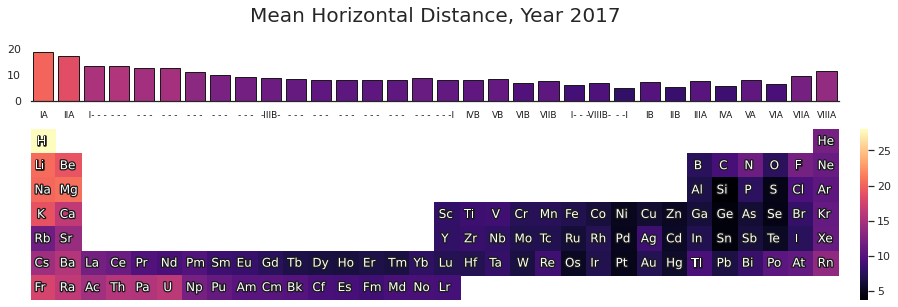

In [280]:
from HND_funcs import *

grid_kws = {'width_ratios': (0.99, 0.01), 
            'height_ratios':(0.3,0.7),
            'wspace': 0.05,'hspace':0.23}

dates = [2017]#1818,1867,1970,

for d in dates:
    N = simMat_yr[d-min_yr]
    with np.errstate(invalid='ignore',divide='ignore'):
        hnd = np.diag(N@D)/(N.sum(axis=0) - np.diag(N))
    
    dt = np.zeros((7,32))*np.nan
    for i,e in enumerate(elemList_AO):
        y,x = TP[e]
        dt[y,x] = hnd[i]

    min_scale = np.nanmin(dt)
    max_scale = np.nanmax(dt)

    fig, ax = plt.subplots(2, 2, gridspec_kw = grid_kws, figsize = (15, 5))

    makeTPPlot(dt,title=f"Mean Horizontal Distance, Year {d}",PT=TP,fs=10,ax=ax,
               min_scale=min_scale,max_scale=max_scale)
    plt.show()